<a href="https://colab.research.google.com/github/Zash2000/Parkinsons-Disease-Classifier-/blob/main/Parkinson's_disease_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parkinson's Disease Classification using Machine Learning

## Introduction
##### This notebook demonstrates classification of Parkinson’s disease using speech data features.
##### Three models are built: Logistic Regression (with L1 regularisation), Random Forest, and Support Vector Machine (with Recursive Feature Elimination).
##### Performance will be evaluated using AUC, classification reports, confusion matrices, and ROC curves.

### Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

###  Loading and Preparing the Data


In [ ]:
# Load dataset
df = pd.read_csv("pd_speech_features.csv")

# Separate features and target variable
X = df.drop(columns=["class"])
y = df["class"]

###Splitting of data

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

###Feature Scaling

In [ ]:
# Scale features to have mean=0 and std=1, important for models like Logistic Regression and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression with L1 Regularisation (LASSO)



=== Logistic Regression (L1) ===
AUC: 0.8428
              precision    recall  f1-score   support

           0       0.71      0.64      0.67        58
           1       0.88      0.91      0.90       169

    accuracy                           0.84       227
   macro avg       0.80      0.77      0.78       227
weighted avg       0.84      0.84      0.84       227



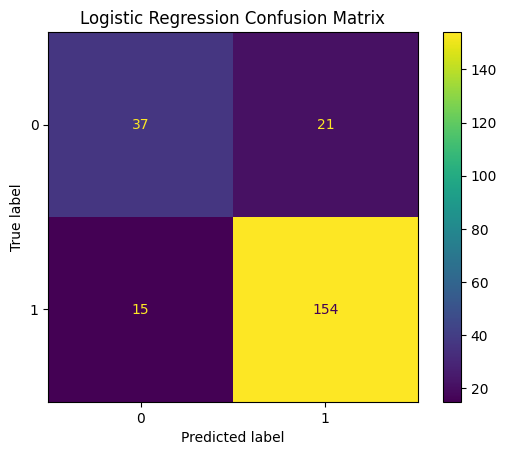

In [ ]:
print("\n=== Logistic Regression (L1) ===")

# Fit logistic regression with L1 penalty for feature selection
lasso = LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced")
lasso.fit(X_train_scaled, y_train)

# Select important features based on the L1 coefficients
selector_lr = SelectFromModel(lasso, prefit=True)
X_train_lr = selector_lr.transform(X_train_scaled)
X_test_lr = selector_lr.transform(X_test_scaled)

# Hyperparameter tuning for logistic regression regularisation strength (C)
logistic_final = LogisticRegression(solver="liblinear", class_weight="balanced")
param_logistic = {"C": [0.01, 0.1, 1, 10]}
grid_log = GridSearchCV(logistic_final, param_logistic, cv=10, scoring="roc_auc")
grid_log.fit(X_train_lr, y_train)

# Predict probabilities and classes on test set
log_probs = grid_log.predict_proba(X_test_lr)[:, 1]
log_preds = grid_log.predict(X_test_lr)

# Display evaluation metrics
print(f"AUC: {roc_auc_score(y_test, log_probs):.4f}")
print(classification_report(y_test, log_preds))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, log_preds)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

###Random Forest Classifier


=== Random Forest ===
AUC: 0.9517
              precision    recall  f1-score   support

           0       0.90      0.66      0.76        58
           1       0.89      0.98      0.93       169

    accuracy                           0.89       227
   macro avg       0.90      0.82      0.85       227
weighted avg       0.90      0.89      0.89       227



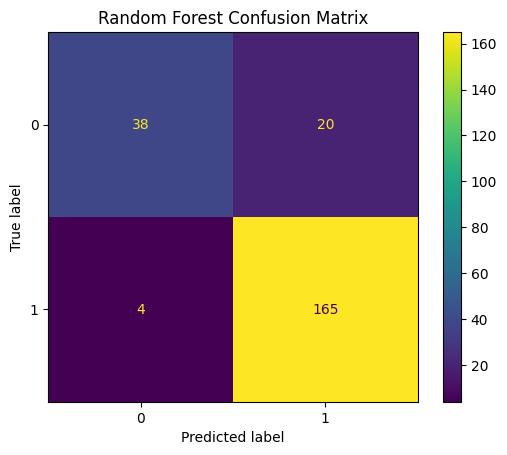

In [ ]:
# === Random Forest with Pipeline ===
print("\n=== Random Forest ===")

# Baseline model to select features
rf_base = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

# Feature selector using prefit model
selector = SelectFromModel(estimator=rf_base, threshold="median")

# Final tuned model
rf_final = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_split=4,
    criterion="entropy",
    bootstrap=False,
    random_state=42,
    class_weight="balanced",
)

# Fit baseline model for feature selection
rf_base.fit(X_train, y_train)
selector.fit(X_train, y_train)  # Important: now uses DataFrame with feature names

# Create pipeline with scaling, feature selection, and final model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selector', selector),
    ('rf', rf_final)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict probabilities and classes
rf_probs = pipeline.predict_proba(X_test)[:, 1]
rf_preds = pipeline.predict(X_test)

# Evaluation
print(f"AUC: {roc_auc_score(y_test, rf_probs):.4f}")
print(classification_report(y_test, rf_preds))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds)
plt.title("Random Forest Confusion Matrix")
plt.show()


###Support Vector Machine with RFE


=== Support Vector Machine (RFE) ===
AUC: 0.8720
              precision    recall  f1-score   support

           0       0.70      0.72      0.71        58
           1       0.90      0.89      0.90       169

    accuracy                           0.85       227
   macro avg       0.80      0.81      0.81       227
weighted avg       0.85      0.85      0.85       227



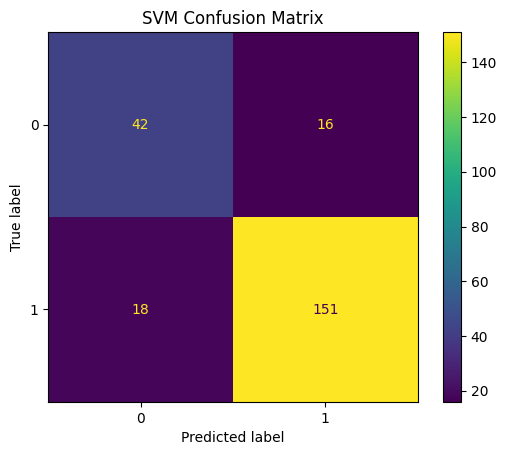

In [ ]:
print("\n=== Support Vector Machine (RFE) ===")

# Initialize SVM with linear kernel for RFE feature selection
svm = SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42)
rfe_svm = RFE(estimator=svm, n_features_to_select=30)
rfe_svm.fit(X_train_scaled, y_train)

# Transform data to select features
X_train_svm = rfe_svm.transform(X_train_scaled)
X_test_svm = rfe_svm.transform(X_test_scaled)

# Train final SVM model on selected features
svm_final = SVC(kernel="linear", probability=True, class_weight="balanced", random_state=42)
svm_final.fit(X_train_svm, y_train)

# Predict probabilities and classes on test set
svm_probs = svm_final.predict_proba(X_test_svm)[:, 1]
svm_preds = svm_final.predict(X_test_svm)

# Display evaluation metrics
print(f"AUC: {roc_auc_score(y_test, svm_probs):.4f}")
print(classification_report(y_test, svm_preds))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, svm_preds)
plt.title("SVM Confusion Matrix")
plt.show()

### Comparison of Model Performance


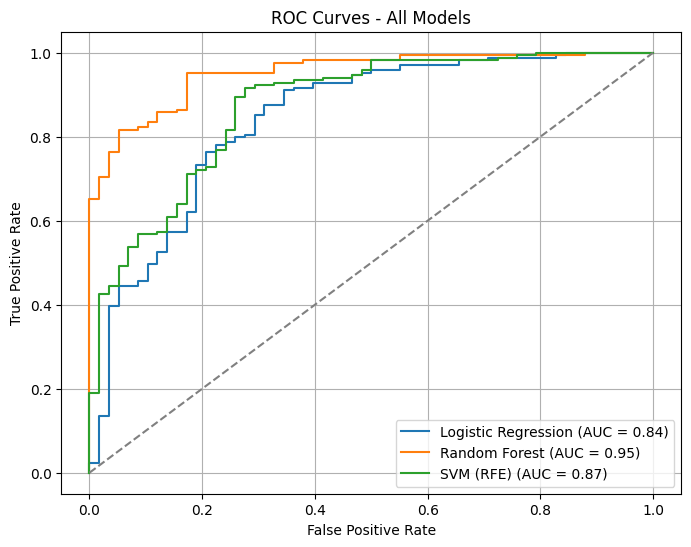

In [ ]:
plt.figure(figsize=(8, 6))

# Plot ROC curve for each model with AUC in legend
for model_name, probs in zip(
    ["Logistic Regression", "Random Forest", "SVM (RFE)"],
    [log_probs, rf_probs, svm_probs],
):
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_score(y_test, probs):.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - All Models")
plt.legend()
plt.grid()
plt.show()

###Conclusion

##### - All models demonstrated reasonable predictive performance, with Random Forest achieving the highest AUC.
##### - Feature selection helped improve model efficiency and interpretability.
##### - Further tuning and exploration of advanced methods may improve classification performance.
##### - This work highlights the use of machine learning on biomedical data for disease diagnosis.
